In [19]:
#Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import yfinance as yf
import numpy as np

#1. Diabetes data analysis

      AGE   SEX   BMI    BP    S1    S2    S3    S4    S5    S6
AGE  1.00  0.17  0.19  0.34  0.26  0.22 -0.08  0.20  0.27  0.30
SEX  0.17  1.00  0.09  0.24  0.04  0.14 -0.38  0.33  0.15  0.21
BMI  0.19  0.09  1.00  0.40  0.25  0.26 -0.37  0.41  0.45  0.39
BP   0.34  0.24  0.40  1.00  0.24  0.19 -0.18  0.26  0.39  0.39
S1   0.26  0.04  0.25  0.24  1.00  0.90  0.05  0.54  0.52  0.33
S2   0.22  0.14  0.26  0.19  0.90  1.00 -0.20  0.66  0.32  0.29
S3  -0.08 -0.38 -0.37 -0.18  0.05 -0.20  1.00 -0.74 -0.40 -0.27
S4   0.20  0.33  0.41  0.26  0.54  0.66 -0.74  1.00  0.62  0.42
S5   0.27  0.15  0.45  0.39  0.52  0.32 -0.40  0.62  1.00  0.46
S6   0.30  0.21  0.39  0.39  0.33  0.29 -0.27  0.42  0.46  1.00


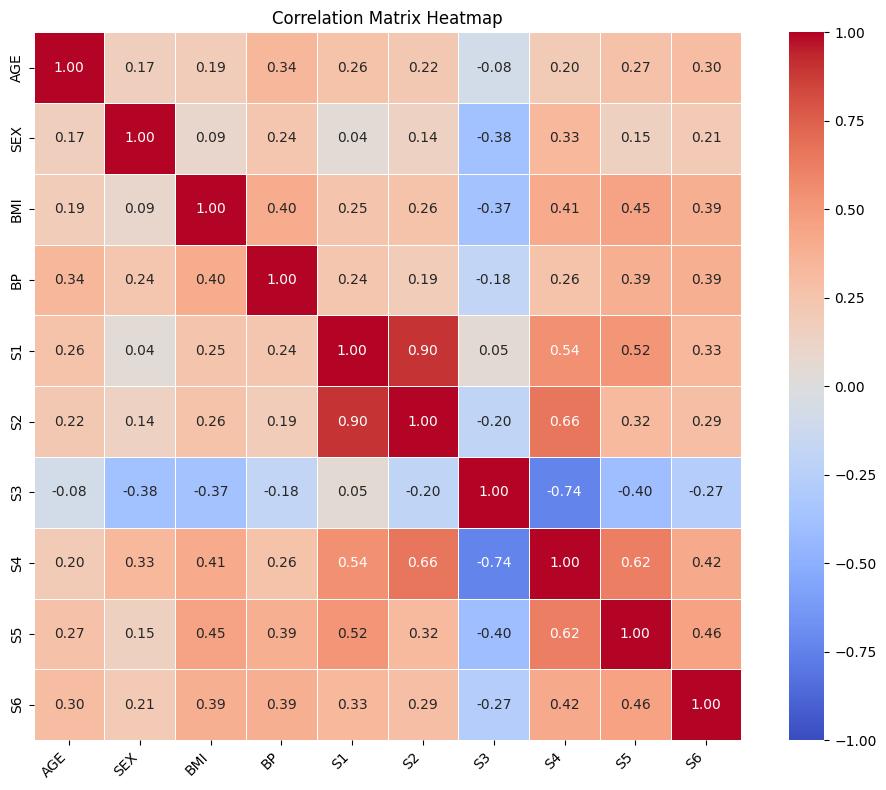

In [20]:
##1.1 Correlation matrix of the explanatory variables and its heat-map
#Correlation matrix

#dataset loading
file_path = 'Diabetes_Data.xlsx'
sheet_name = 'Diabetes_Data'
df = pd.read_excel(file_path, sheet_name)

explanatory_vars = df.iloc[:, :10]
corr_matrix = explanatory_vars.corr().round(2)
print(corr_matrix)

#Correlation matrix heat-map
plt.figure(figsize=(10,8))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=0.5
)

plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [21]:
##1.3 Multivariate Linear Model
#Data preparation
X = df.drop(columns=['Y'])
y = df['Y']

#Adding a constant to the model
X_with_const = sm.add_constant(X)

#Creating and fitting the multivarate linear model
model = sm.OLS(y, X_with_const).fit()

#Mean Squared Error (MSE) Calculation
y_pred = model.predict(X_with_const)
mse = mean_squared_error(y, y_pred)

#Adjusted R-squared
adj_r2 = model.rsquared_adj

#Collinearity checking
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

#Results
print(f"Mean Squared Error: {mse:.4f}")
print(f"Adjusted R-squared: {adj_r2:.4f}")
print("\n--- Model Summary ---")
print(model.summary())

Mean Squared Error: 2859.6963
Adjusted R-squared: 0.5066

--- Model Summary ---
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Mon, 12 Jan 2026   Prob (F-statistic):           3.83e-62
Time:                        17:55:20   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [22]:
print("\n--- Variance Inflation Factors ---")
print(vif_data)


--- Variance Inflation Factors ---
  Feature         VIF
0     AGE   17.876909
1     SEX   12.192347
2     BMI   55.155355
3      BP   69.404363
4      S1  576.886424
5      S2  244.913298
6      S3   52.293365
7      S4   81.350054
8      S5  277.183350
9      S6   93.976986


In [23]:
##1.5 model composition with forward selection
#preparing indeoendent (X) and dependent (y) variables
X = df.drop(columns=['Y'])
y = df['Y']

#Foward Selection Function Definition
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []

    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features, dtype='float64')

        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
            print(f"Added {new_pval.idxmin():<4} with p-value: {min_p_value:.4e}")
        else:
            break
    return best_features

#running the forward selection
print("Starting Forward Selection...")
selected_features = forward_selection(X, y)

#A final model with selected features
X_selected = sm.add_constant(X[selected_features])
final_model = sm.OLS(y, X_selected).fit()

#Performance matrics calculation
y_pred = final_model.predict(X_selected)
mse = mean_squared_error(y, y_pred)
r2 = final_model.rsquared
adj_r2 = final_model.rsquared_adj

#results visualization
print("\n" + "="*30)
print("FINAL STEP MODEL RESULTS")
print("="*30)
print(f"Selected Variables: {selected_features}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared:  {r2:.4f}")
print(f"Adusted R-squared: {adj_r2:.4f}")
print("\n--- Modal Summary ---")
print(final_model.summary())

Starting Forward Selection...
Added BMI  with p-value: 3.4660e-42
Added S5   with p-value: 3.0396e-20
Added BP   with p-value: 3.7426e-05
Added S1   with p-value: 1.4544e-03
Added SEX  with p-value: 9.2306e-03
Added S2   with p-value: 2.7230e-04

FINAL STEP MODEL RESULTS
Selected Variables: ['BMI', 'S5', 'BP', 'S1', 'SEX', 'S2']
Mean Squared Error: 2876.6833
R-squared:  0.5149
Adusted R-squared: 0.5082

--- Modal Summary ---
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     76.95
Date:                Mon, 12 Jan 2026   Prob (F-statistic):           3.01e-65
Time:                        17:55:33   Log-Likelihood:                -2387.3
No. Observations:                 442   AIC:                             4789.
Df Residuals:     

#2. Titanic Data set Analysis

In [24]:
#Dataset loading
titanic = pd.read_csv("titanic3.csv")

In [25]:

#2.2 Calculating the overall survival propability for passengers.

probability_survival = titanic["survived"].mean().round(5)
print(probability_survival)

0.38197


In [26]:
##2.3 Survival probability by passenger class, gender, and age.

titanic = titanic[["pclass", "sex", "age", "survived"]]
age_bins = [0,12,18,35,60,100]
age_labels = ["Child", "Teen", "Young Adult", "Adult", "Senior"]

titanic["age_group"] = pd.cut(
    titanic["age"],
    bins=age_bins,
    labels=age_labels
)

survival_table = (
    titanic
    .groupby(["pclass", "sex", "age_group"])["survived"]
    .mean()
    .reset_index()
)

survival_table

C:\Users\StanslausRK\AppData\Local\Temp\ipykernel_12636\3698372443.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["pclass", "sex", "age_group"])["survived"]


,pclass,sex,age_group,survived
0,1,female,Child,0.000000
1,1,female,Teen,1.000000
2,1,female,Young Adult,0.981132
3,1,female,Adult,0.967213
4,1,female,Senior,0.833333
5,1,male,Child,1.000000
6,1,male,Teen,0.500000
7,1,male,Young Adult,0.431818
8,1,male,Adult,0.321429
9,1,male,Senior,0.066667


In [27]:
#2.4 logistic regression model
titanic = titanic[["survived", "pclass", "sex", "age"]].dropna()


titanic["sex"] = titanic["sex"].map({"female": 0, "male": 1})

X = titanic[["pclass", "sex", "age"]]
X = sm.add_constant(X)
y = titanic["survived"]

logit_model = sm.Logit(y, X)
result = logit_model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.469897
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 1046
Model:                          Logit   Df Residuals:                     1042
Method:                           MLE   Df Model:                            3
Date:                Mon, 12 Jan 2026   Pseudo R-squ.:                  0.3051
Time:                        17:56:05   Log-Likelihood:                -491.51
converged:                       True   LL-Null:                       -707.31
Covariance Type:            nonrobust   LLR p-value:                 3.167e-93
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5893      0.406     11.311      0.000       3.794       5.385
pclass        -1.1332      0.112    -10.142      0.000      -1.352      -0.914
sex           -2.4974      0.166    -15.033      0.000      -2.823      -2.172
age           -0.0339      0.006     -5.395      0.000      -0.046      -0.022
==============================================================================
"""

In [29]:
##2.5 Model performance accuracy based on confusion matrix
#data cleaning
df = pd.read_csv('titanic3.csv')
df_clean = df[['pclass', 'sex', 'age', 'survived']].dropna()
df_clean['sex_female'] = (df_clean['sex'] == 'female').astype(int)

#Variable definition and adding constant
X = df_clean[['pclass', 'sex_female', 'age']]
y = df_clean['survived']
X = sm.add_constant(X)

#Fitting the Logistic Regression model
model = sm.Logit(y, X).fit()
y_prob = model.predict(X)
y_pred = (y_prob > 0.5).astype(int)

#Cunfusion Matrix and Accuracy calculation
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

print("Cunfusion Matrix:")
print(cm)
print(f"Classification Accuracy: {accuracy:.4f}")


Optimization terminated successfully.
         Current function value: 0.469897
         Iterations 6
Cunfusion Matrix:
[[523  96]
 [126 301]]
Classification Accuracy: 0.7878


#3. Principal Component Analysis

[*********************100%***********************]  30 of 30 completed


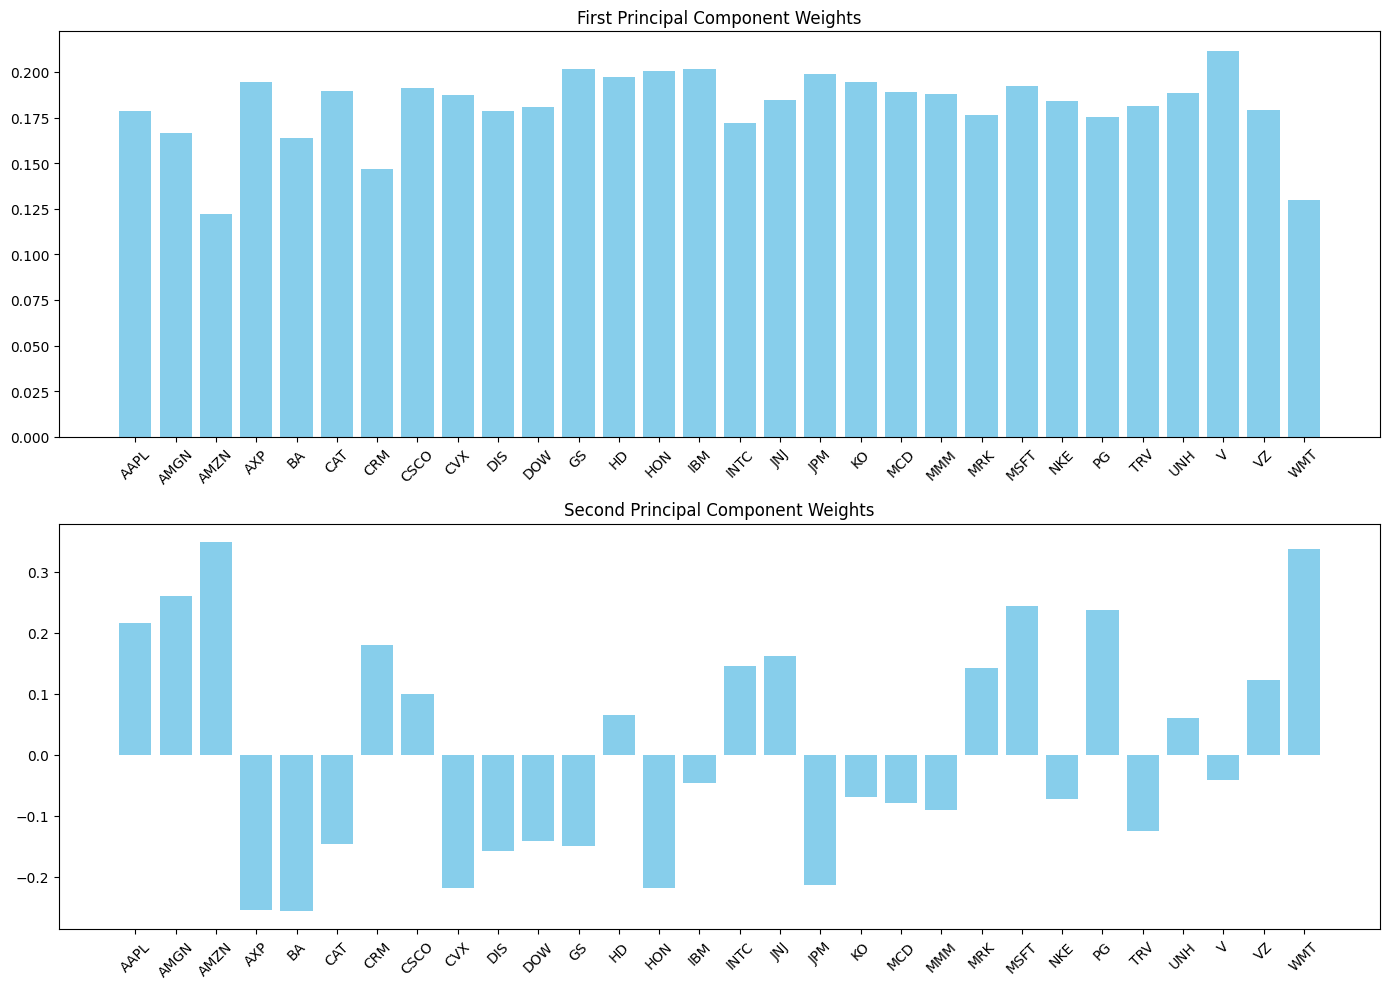

In [30]:
##3.3 Dow Jones constituents stocks analysis
#Tickers and Date Range Definition
tickers = [
    'MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 
    'DOW','GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 
    'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'AMZN', 'WMT'
]
start_date = '2020-01-01'
end_date = '2021-01-01'

#Data downloading
raw_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
data = raw_data['Close'].dropna(axis=1, how='all')
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(-1)
else:
    data.columns = [str(c) for c in data.columns]

#Daily return calculation
returns = data.pct_change().dropna()

#Correlation Matrix calculation
corr_matrix = returns.corr()

#Perfoming PCA
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns)

pca = PCA()
pca.fit(scaled_returns)

#weights extraction of the first two components
pc1_weights = pca.components_[0]
pc2_weights = pca.components_[1]
stock_names = returns.columns

#visualizaton-graphs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

#pc1 plot
ax1.bar(stock_names, pc1_weights, color='skyblue')
ax1.set_title('First Principal Component Weights')
ax1.tick_params(axis='x', rotation=45)

#pc2 plot
ax2.bar(stock_names, pc2_weights, color='skyblue')
ax2.set_title('Second Principal Component Weights')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

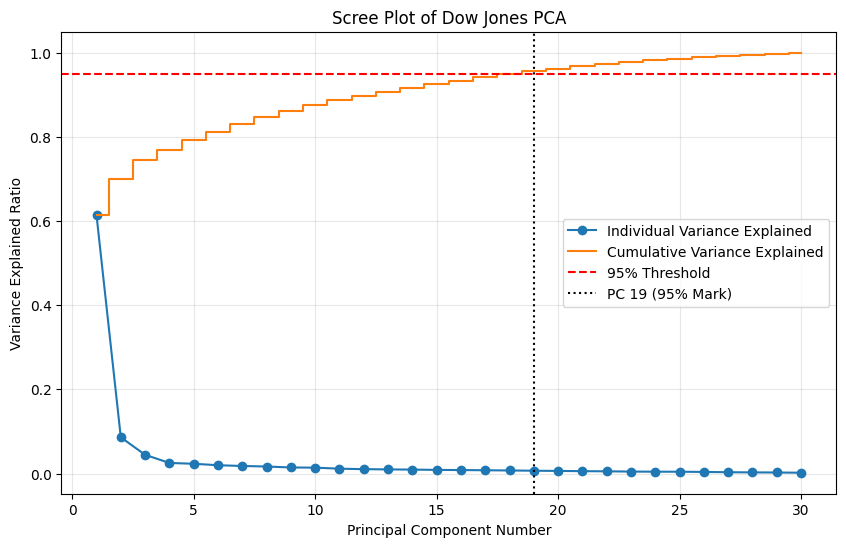

Number of principal components required for 95% variance: 19


In [31]:
##3.4 Variance Calculation

#Variance Explained calculation
exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)

#number of component required for 95% variance
n_95 = np.where(cum_var >= 0.95)[0][0] + 1

#Scree plotting
plt.figure(figsize=(10, 6))

#individual variance plotting
plt.plot(range(1, len(exp_var) + 1), exp_var, 'o-', label='Individual Variance Explained')

#Cumulative variance plotting
plt.step(range(1, len(cum_var) + 1), cum_var, where='mid', label='Cumulative Variance Explained')

#95% threshold line
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.axvline(x=n_95, color='black', linestyle=":", label=f'PC {n_95} (95% Mark)')

plt.title('Scree Plot of Dow Jones PCA')
plt.xlabel('Principal Component Number')
plt.ylabel('Variance Explained Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Number of principal components required for 95% variance: {n_95}")


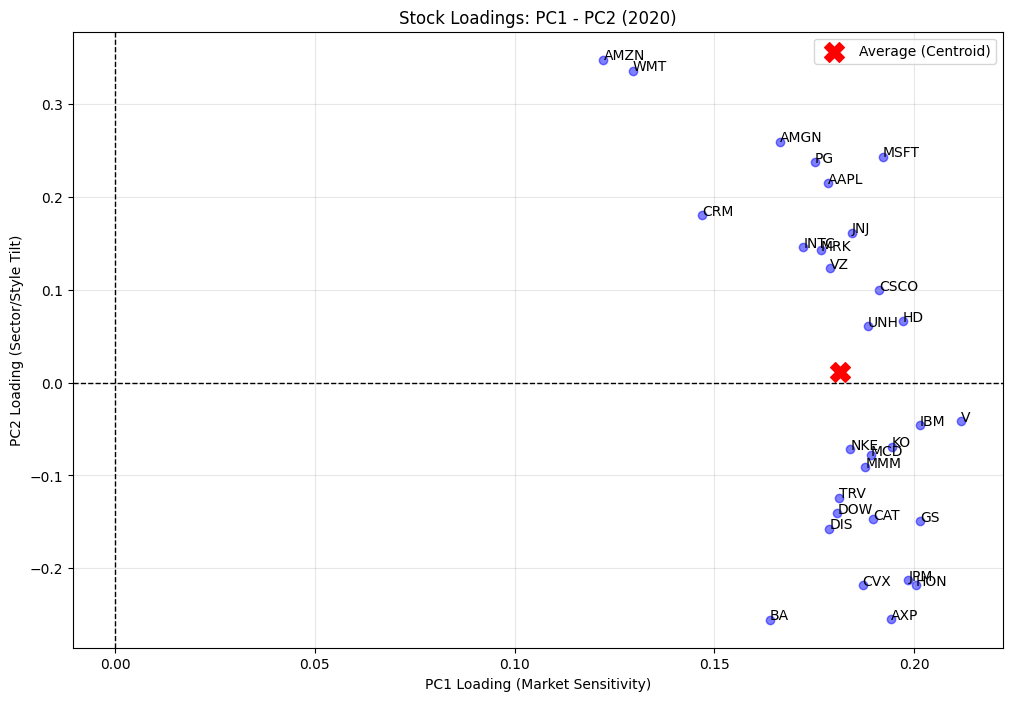

Three most distant stocks from the average:
   Stock  Distance
2   AMZN  0.341690
29   WMT  0.328941
4     BA  0.267609


In [32]:
##3.5 All 30 stocks average calculation by investigating the scatter plot of the 1st two principal components.

#Coordinates extraction of each stock in the PC1-PC2 space
coords = np.column_stack((pca.components_[0], pca.components_[1]))

#average stock calculation
average_coord = np.mean(coords, axis=0)

#Euclidean Distances calculation of ach stock to the average distance
distances = np.sqrt(np.sum((coords - average_coord)**2, axis=1))

#Results dataframe
dist_df = pd.DataFrame({
    'Stock': stock_names,
    'PC1_Loading': coords[:, 0],
    'PC2_Loading': coords[:, 1],
    'Distance': distances
}).sort_values(by='Distance', ascending=False)

#Plotting the Scatter Plot
plt.figure(figsize=(12, 8))
plt.scatter(dist_df['PC1_Loading'], dist_df['PC2_Loading'], alpha=0.5, color='blue')

#Stock labelling
for i, txt in enumerate(dist_df['Stock']):
    plt.annotate(txt, (dist_df['PC1_Loading'].iloc[i], dist_df['PC2_Loading'].iloc[i]))

#Plotting the average point
plt.scatter(average_coord[0], average_coord[1], color='red', marker='X', s=200, label='Average (Centroid)')

plt.title('Stock Loadings: PC1 - PC2 (2020)')
plt.xlabel('PC1 Loading (Market Sensitivity)')
plt.ylabel('PC2 Loading (Sector/Style Tilt)')
plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Three most distant stocks from the average:")
print(dist_df[['Stock', 'Distance']].head(3))